### IE801(B) Logistics Management HW2

- Lee Kanghoon (**LKH**), 20203421

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import copy

import gurobipy as gp
from gurobipy import GRB
from itertools import product, tee, combinations

### Problem 1 : Generate TSP instances of n=20, 50, 100 randomly.

    
- generate_instance
    - 도시의 갯수를 받아서 그에 따른 정수 기반 위치를 반환.
    
    
- visualize_points
    - 도시들의 (x, y) 좌표를 받아서 visualize
    - tour path도 넘겨주면 그에 따른 path도 visualize.

In [2]:
def generate_instance(num_nodes, out_type=None):
    x = np.random.randint(100, size=num_nodes)
    y = np.random.randint(100, size=num_nodes)
    if out_type:
        return x.astype(out_type), y.astype(out_type)
    return x, y

In [3]:
def visualize_points(x, y, title=None, tour=None, show_number=False):

    border = 5
    plt.xlim(0 - border, 100 + border)
    plt.ylim(0 - border, 100 + border)
    
    plt.xticks([])
    plt.yticks([])
    
    if title:
        plt.title(title)
    
    if tour is None:
        plt.scatter(x, y)
    else:
        plt.plot(x[tour], y[tour], marker='o')
    
    if show_number:
        for i in range(x.shape[0]):
            plt.text(x[i], y[i], str(i), color="red", fontsize=12)
        
    plt.show()
    plt.close('all')

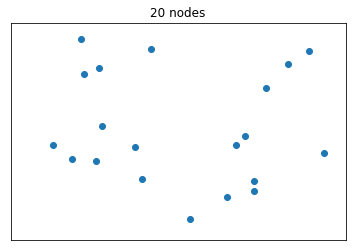

In [4]:
x, y = generate_instance(20)
visualize_points(x, y, "20 nodes")

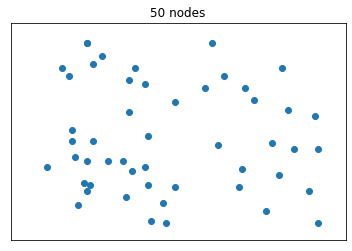

In [5]:
x, y = generate_instance(50)
visualize_points(x, y, "50 nodes")

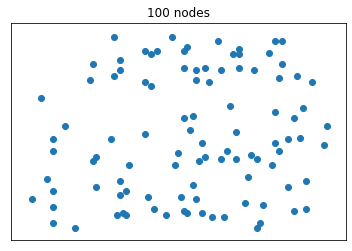

In [6]:
x, y = generate_instance(100)
visualize_points(x, y, "100 nodes")

### Problem 2 : Solve the problems using Gurobi and lazy constraints.

![nn](./Images/HW2_image1.png)

Reference : https://www.gurobi.com/documentation/9.1/examples/tsp_py.html

- get_cost
    - 도시들의 (x, y) 좌표를 받아서 i 도시에서 j 도시까지의 거리를 계산한 numpy array를 반환.
    
    
- subtourelim
    - TSP MILP 문제를 풀다가 solution을 찾게 되면 call 되는 function. 
    - subtour의 존재여부를 파악한 뒤, 만약 존재하면 subtour를 제거할 수 있도록 그에 맞는 constraint (2.11) 를 추가.
    - lazy constraint가 적용되는 부분.
    
    
- subtour
    - edge들간의 연결관계를 받아서, 가장 작은 subtour를 반환.
    
    
- solve_TSP
    - 도시들의 (x, y) 좌표를 받아서 minimum cost tour path를 반환. 
    - solve TSP MILP with gurobi.
    - (2.8), (2.9), (2.10), (2.12) 식이 구현되어 있음.

In [7]:
def get_cost(x, y, integer=True):
    
    x_ = x.copy().reshape(-1, 1)
    y_ = y.copy().reshape(-1, 1)
    cost = np.sqrt((x - x_) ** 2 + (y - y_) ** 2)

    if integer:
        return np.round(cost, 0).astype(dtype=np.int64)
    else:
        return cost

In [8]:
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys() if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        n = int(model.ModelName)
        tour = subtour(selected, n)
        
        if len(tour) < n:
            out_nodes = list(set(range(n)) - set(tour))
            in_nodes = tour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in product(out_nodes, in_nodes)) >= 1)

In [9]:
def subtour(edges, n):
    unvisited = list(range(n))
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*') if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

In [10]:
def Gurobi_solve_TSP(x, y):
    num_nodes = x.shape[0]
    cost = get_cost(x, y)
    
    model = gp.Model(name=str(num_nodes))
    model.Params.LogToConsole = 0
    variables = gp.tupledict()

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                variables[i, j] = model.addVar(obj=cost[i][j], vtype=GRB.BINARY, name=str(num_nodes))

    for i in range(num_nodes):
        temp_list = list(range(num_nodes))
        temp_list.pop(i)
        model.addConstr(sum(variables[i, j] for j in temp_list) == 1)
        model.addConstr(sum(variables[j, i] for j in temp_list) == 1)

    model._vars = variables
    model.Params.lazyConstraints = 1
    model.optimize(subtourelim)

    vals = model.getAttr('x', variables)
    selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

    tour = subtour(selected, num_nodes)
    assert len(tour) == num_nodes
    
    tour = tour + [0]
    return tour, model.objVal

#### Problem 2-1 : 20 Cities

In [52]:
def visualize_points_solution(x, y, title=None, tour=None, show_number=False):
        
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    border = 5
    plt.xlim(0 - border, 100 + border)
    plt.ylim(0 - border, 100 + border)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(x, y)
    
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    border = 5
    plt.xlim(0 - border, 100 + border)
    plt.ylim(0 - border, 100 + border)
    plt.xticks([])
    plt.yticks([])
    
    if title:
        plt.title(title[1])
    
    plt.plot(x[tour], y[tour], marker='o')
        
    plt.show()
    plt.close('all')

solved with Gurobi
cost :  403.0


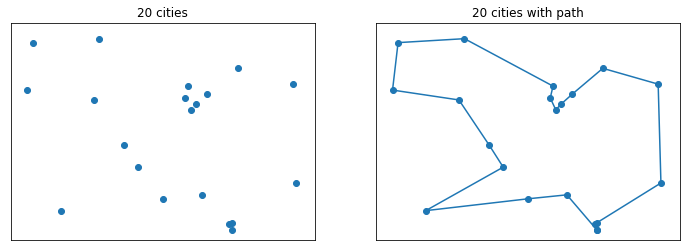

In [53]:
x, y = generate_instance(20)
tour, cost = Gurobi_solve_TSP(x, y)
print("solved with Gurobi")
print("cost : ", cost)

visualize_points_solution(x, y, ['20 cities', '20 cities with path'], tour)

#### Problem 2-2 : 50 Cities

solved with Gurobi
cost :  556.0


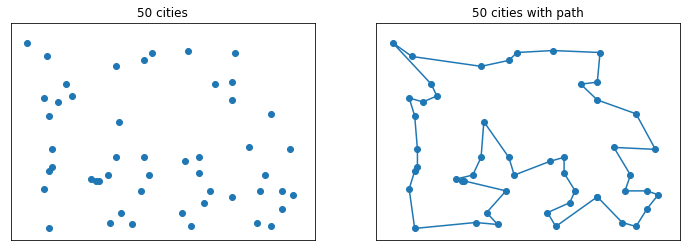

In [54]:
x, y = generate_instance(50)
tour, cost = Gurobi_solve_TSP(x, y)
print("solved with Gurobi")
print("cost : ", cost)

visualize_points_solution(x, y, ['50 cities', '50 cities with path'], tour)

#### Problem 2-3 : 100 Cities

solved with Gurobi
cost :  773.0


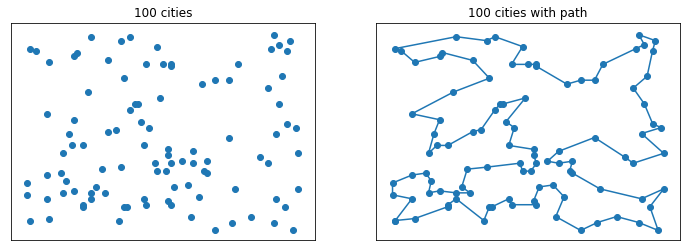

In [55]:
x, y = generate_instance(100)
tour, cost = Gurobi_solve_TSP(x, y)
print("solved with Gurobi")
print("cost : ", cost)

visualize_points_solution(x, y, ['100 cities', '100 cities with path'], tour)

### Problem 3 : Solve the problems using the Concorde and LKH solvers.

In [42]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [43]:
%julia using PyCall

%julia using Concorde
%julia using LKH

In [57]:
num_nodes = 100
x, y = generate_instance(num_nodes, np.float64)

In [58]:
%%julia

x = py"""x"""
y = py"""y"""
opt_tour, opt_len = Concorde.solve_tsp(x, y; dist="EUC_2D")
println("solved with Concorde!")
println("cost : ", opt_len)


solved with Concorde!
cost : 760

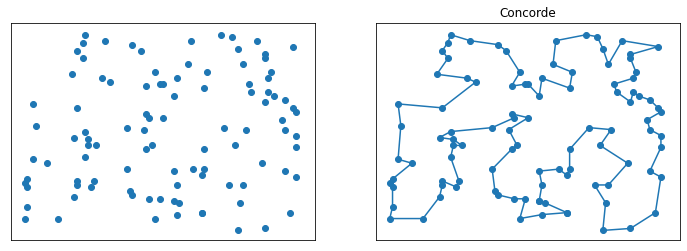

In [59]:
tour = %julia opt_tour
tour = np.append(tour - 1, [0])

visualize_points_solution(x, y, ['', 'Concorde'], tour)

In [98]:
%%julia

x = py"""x"""
y = py"""y"""
opt_tour, opt_len = LKH.solve_tsp(x, y; dist="EUC_2D")
println("solved with LKH!")
println("cost : ", opt_len)

solved with LKH!
cost : 586

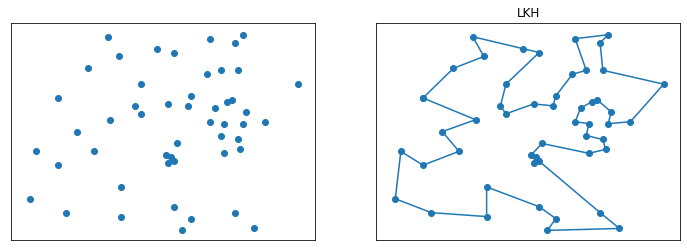

In [99]:
tour = %julia opt_tour
tour = np.append(tour - 1, [0])

visualize_points_solution(x, y, ['', 'LKH'], tour)

### Problem 4 : Implement the following heuristic algorithms to solve the problems

- Nearest Neighbor
- Greedy Algorithm
- Nearest Insertion
- Farthest Insertion
- Christofides
- 2-opt Exchange

Reference : Johnson, David S. "Local optimization and the traveling salesman problem." International colloquium on automata, languages, and programming. Springer, Berlin, Heidelberg, 1990.

In [62]:
num_nodes = 50
x, y = generate_instance(num_nodes, np.float64)

#### Prob 4-1 : Nearest Neighbor

Starting from an arbitrarily chosen initial city, repeatedly choose for the next city the unvisited city closest to the current one. Once all cities have been chosen, close the tour by returning to the initial city. 

*pseudocode* : https://www2.isye.gatech.edu/~mgoetsch/cali/VEHICLE/TSP/TSP009__.HTM

- Step 1. Start with any node as the beginning node
- Step 2. Find the unvisited node closest to the last node added to the path. Add this node to the path.
- Step 3. Repeat Step 2 until all nodes are contained in the path. Then join the first and last nodes.

In [63]:
def solve_TSP_NearestNeighbor(x, y):
    
    num_nodes = x.shape[0]
    cost = get_cost(x, y)
    cost_ = cost.copy()
    np.fill_diagonal(cost, 10e+6)
    
    cur_node = np.random.randint(num_nodes, size=1)[0]
    start_node = cur_node
    tour = [cur_node]
    tour_cost = 0
    
    while len(tour) <= num_nodes - 1:
        next_node = cost[cur_node].argmin()
        cur_cost = cost[cur_node][next_node]
        
        cost[cur_node] = 10e+6
        cost[:, cur_node] = 10e+6

        cur_node = next_node

        tour.append(cur_node)
        tour_cost += cur_cost
        
    tour = tour + [tour[0]]
    tour_cost += cost_[cur_node][start_node]
    
    return np.array(tour), tour_cost

solved with Nearest Neighbor
cost :  693


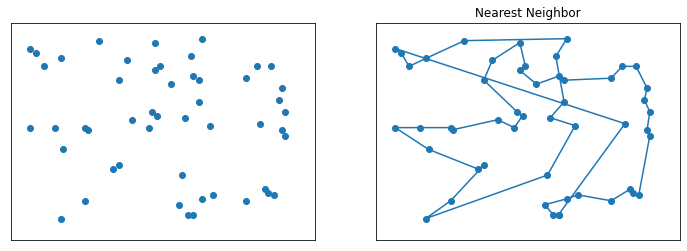

In [65]:
tour, cost = solve_TSP_NearestNeighbor(x, y)
print("solved with Nearest Neighbor")
print("cost : ", cost)

visualize_points_solution(x, y, ['', 'Nearest Neighbor'], tour)

#### Prob 4-2 : Greedy Algorithm

Go through the city pairs in order by non-decreasing distance, adding the corresponding edge to the tour whenever doing so will neither create a vertex of degree exceeding two nor a cycle with less than $N$ cities. 

In [66]:
def get_cost_variant(x, y):
    
    n = x.shape[0]
    cost = get_cost(x, y)
    
    cost_ = []
    for i in range(n):
        for j in range(n):
            if j > i:
                cost_.append([i, j, cost[i][j]])

    return cost, np.array(cost_)

In [67]:
def solve_TSP_GreedyAlgorithm(x, y):
    
    num_nodes = x.shape[0]
    cost_, cost = get_cost_variant(x, y)
    
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    tour_cost = 0
    
    while G.number_of_edges() < num_nodes - 1:
        min_edge = cost[:, 2].argmin()
        i, j = cost[min_edge][0], cost[min_edge][1]
        G.add_edge(i, j)
        added = True

        try:
            cycle = nx.find_cycle(G)
            G.remove_edge(i, j)
            added = False
        except:
            for node, degree in G.degree([i, j]):
                if degree > 2:
                    G.remove_edge(i, j)
                    added = False
                    
        if added : tour_cost += cost[min_edge][-1]
        cost[min_edge][-1] = 10e+6
    
    G_degree = np.array(G.degree())
    start, end = G_degree[G_degree[:, 1] == 1][:, 0]
    tour = list(nx.all_simple_paths(G, start, end))[0]
    
    tour = tour + [tour[0]]
    tour_cost += cost_[start][end]
    
    return tour, tour_cost

solved with Greedy Algorithm
cost :  641


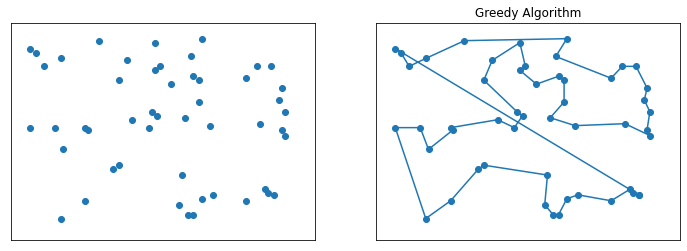

In [69]:
tour, cost = solve_TSP_GreedyAlgorithm(x, y)
print("solved with Greedy Algorithm")
print("cost : ", cost)

visualize_points_solution(x, y, ['', 'Greedy Algorithm'], tour)

#### Prob 4-3 : Nearest Insertion

Starting from a degenerate tour consisting of the two closest cities, repeatedly choose the non-tour city with the minimum distance to its nearest neighbor among the tour cities, and insert it in between the two consecutive tour cities for which such an insertion causes the minimum increase in total tour length.

*pseudocode :* https://www2.isye.gatech.edu/~mgoetsch/cali/VEHICLE/TSP/TSP009__.HTM

- Step 1. Start with a sub-graph consisting of node $i$ only.
- Step 2. Find node $r$ such that cir is minimal and form sub-tour $i-r-i$.
- Step 3. (Selection step) Given a sub-tour, find node $r$ not in the sub-tour closest to any node $j$ in the sub-tour; i.e. with minimal $c_{rj}$
- Step 4. (Insertion step) Find the arc $(i, j)$ in the sub-tour which minimizes $c_{ir} + c_{rj} - c_{ij}$ . Insert $r$ between $i$ and $j$.
- Step 5. If all the nodes are added to the tour, stop. Else go to step 3

In [70]:
def solve_TSP_NearestInsertion(x, y):
    
    num_nodes = x.shape[0]
    cost = get_cost(x, y)
    cost_ = cost.copy()
    np.fill_diagonal(cost, 10e+6)
    tour_member = np.zeros(num_nodes, dtype=np.int64)

    # find minimum edge segment
    i, j = np.unravel_index(cost.argmin(), cost.shape)
    tour_member[i], tour_member[j] = 1, 1
    cost[tour_member == 1] = 10e+6
    
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edge(i, j)
    first_insertion = True
    
    while G.number_of_edges() < num_nodes:

        # selection step - find r
        r, _ = np.unravel_index(cost[:, tour_member == 1.0].argmin(), 
                                 cost[:, tour_member == 1.0].shape)
        
        # insertion step (1) - find i, j
        minimizer, minimum = None, 10e+6
        for i, j in G.edges():
            cur_value = cost_[i][r] + cost_[r][j] - cost_[i][j]
            if cur_value < minimum:
                minimizer, minimum = (i, j), cur_value
        i, j = minimizer
        
        # inserttion step (2) - insert r
        if first_insertion:
            first_insertion = False
        else:
            G.remove_edge(i, j)
            
        G.add_edges_from([(i, r), (r, j)])
        tour_member[r] = 1
        cost[tour_member == 1] = 10e+6
        
    cycle = nx.find_cycle(G)
    tour = []
    for edge in cycle:
        tour.append(edge[0])
    
    tour = tour + [tour[0]]
    tour_cost = 0
    for i in range(num_nodes):
        tour_cost += cost_[tour[i]][tour[i+1]]
    
    return tour, tour_cost

solved with Nearest Insertion
cost :  634


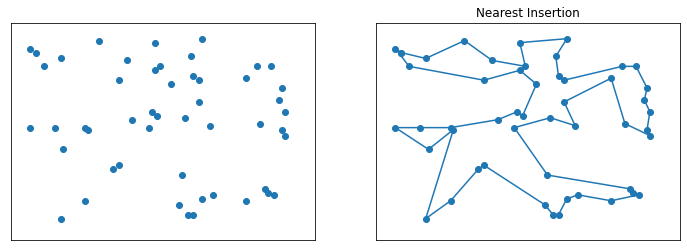

In [72]:
tour, cost = solve_TSP_NearestInsertion(x, y)
print("solved with Nearest Insertion")
print("cost : ", cost)

visualize_points_solution(x, y, ['', 'Nearest Insertion'], tour)

#### Prob 4-4 : Farthest Insertion

Starting from a degenerate tour consisting of the two cities with maximum inter-city distance, repeatedly choose the non-tour city with the maximum distance to its nearest neighbor among the tour cities, and insert it as in Nearest Insertion.

*pseudocode :* https://www2.isye.gatech.edu/~mgoetsch/cali/VEHICLE/TSP/TSP015__.HTM

- Step 1. Start with a sub-graph consisting of node $i$ only.
- Step 2. Find node $r$ such that $c_{ir}$ is maximal and form sub-tour $i-r-i$.
- Step 3. (Selection step) Given a sub-tour, find node $r$ not in the sub-tour farthest from any node in the sub-tour; i.e. with maximal $c_{rj}$
- Step 4. (Insertion step) Find the arc $(i, j)$ in the sub-tour which minimizes $c_{ir} + c_{rj} - c_{ij}$ . Insert $r$ between $i$ and $j$.
- Step 5. If all the nodes are added to the tour, stop. Else go to step 3

In [73]:
def solve_TSP_FarthestInsertion(x, y):
    
    num_nodes = x.shape[0]
    cost = get_cost(x, y)
    cost_ = cost.copy()
    np.fill_diagonal(cost, -1)
    tour_member = np.zeros(num_nodes, dtype=np.int64)

    # find maximum edge segment
    i, j = np.unravel_index(cost.argmax(), cost.shape)
    tour_member[i], tour_member[j] = 1, 1
    cost[tour_member == 1] = -1
    
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edge(i, j)
    first_insertion = True

    while G.number_of_edges() < num_nodes:
        
        # selection step - find r
        r = cost[:, tour_member == 1.0].min(-1).argmax()
        
        # insertion step (1) - find i, j
        minimizer, minimum = None, 10e+6
        for i, j in G.edges():
            cur_value = cost_[i][r] + cost_[r][j] - cost_[i][j]
            if cur_value < minimum:
                minimizer, minimum = (i, j), cur_value
        i, j = minimizer
        
        # inserttion step (2) - insert r
        if first_insertion:
            first_insertion = False
        else:
            G.remove_edge(i, j)
        G.add_edges_from([(i, r), (r, j)])
        tour_member[r] = 1
        cost[tour_member == 1] = -1
    
    cycle = nx.find_cycle(G)
    tour = []
    for edge in cycle:
        tour.append(edge[0])
    tour = tour + [tour[0]]
    
    tour_cost = 0
    for i in range(num_nodes):
        tour_cost += cost_[tour[i]][tour[i+1]]
    
    return tour, tour_cost

solved with Farthest Insertion
cost :  550


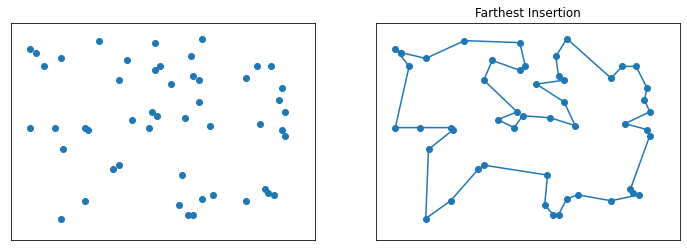

In [74]:
tour, cost = solve_TSP_FarthestInsertion(x, y)
print("solved with Farthest Insertion")
print("cost : ", cost)

visualize_points_solution(x, y, ['', 'Farthest Insertion'], tour)

#### Prob 4-5 : Christofides

Construct a graph consisting of a copy of a minimum spanning tree and a minimum length matching of the odd degree vertices in that tree. Then proceed as in the Double MST algorithm.

*pseudocode : Goodrich, Michael T.; Tamassia, Roberto (2015), "18.1.2 The Christofides Approximation Algorithm", Algorithm Design and Applications, Wiley, pp. 513–514.*  (https://en.wikipedia.org/wiki/Christofides_algorithm#Algorithm)

- Step 1. Create a minimum spanning tree $T$ of $G$.
- Step 2. Let $O$ be the set of vertices with odd degree in $T$. By the handshaking lemma, $O$ has an even number of vertices.
- Step 3. Find a minimum-weight perfect matching $M$ in the induced subgraph given by the vertices from $O$.
- Step 4. Combine the edges of $M$ and $T$ to form a connected multigraph $H$ in which each vertex has even degree. 
- Step 5. Form an Eulerian circuit in $H$.
- Step 6. Make the circuit found in previous step into a Hamiltonian circuit by skipping repeated vertices (shortcutting).

In [75]:
def get_cost_variant2(x, y):
    
    n = x.shape[0]
    cost = get_cost(x, y)
    
    cost_ = []
    for i in range(n):
        for j in range(n):
            if j > i:
                cost_.append((i, j, {'cost': cost[i][j]}))

    return cost, cost_

In [76]:
def solve_TSP_Christofides(x, y):
    
    # step0 : preprocessing
    num_nodes = x.shape[0]
    cost_, cost = get_cost_variant2(x, y)
    
    # step0 : generate G
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(cost)
    
    # step1 : minimum spanning tree, T
    T = nx.minimum_spanning_tree(G, 'cost')
    
    # step2 : find O, the set of vertices with odd degree in T
    T_degree = np.array(T.degree())
    odd_nodes = np.arange(num_nodes)[T_degree[:, 1] % 2 == 1]
    
    # step3 : minimum-weight perfect matching, M
    M = G.subgraph(odd_nodes)
    matching_edges = nx.algorithms.matching.min_weight_matching(M, weight='cost')
    matching_edge_list = []
    for i, j in matching_edges:
        matching_edge_list.append((i, j, {'cost': cost_[i][j]}))
    
    # step4 : multigraph H (combination of M and T)
    H = nx.MultiGraph()
    H.add_nodes_from(range(num_nodes))
    H.add_edges_from(T.edges(data=True))
    H.add_edges_from(matching_edge_list)
    
    # step5 : get an eulerian circuit in H
    eulerian_circuit = nx.algorithms.euler.eulerian_circuit(H)
    
    # step6 : get a hamiltonian circuit by shortcutting
    tour = []
    tour_cost = 0
    visited = np.zeros(num_nodes)
    for i, j in eulerian_circuit:
        if visited[i] == 0:
            tour.append(i)
            visited[i] = 1
    tour = tour + [tour[0]]
    
    tour_cost = 0
    for i in range(num_nodes):
        tour_cost += cost_[tour[i]][tour[i+1]]
    
    return tour, tour_cost

solved with Christofides
cost :  631


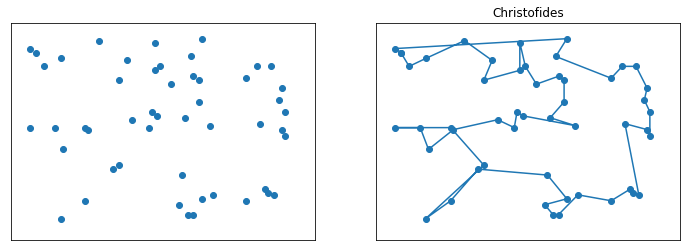

In [77]:
tour, cost = solve_TSP_Christofides(x, y)
print("solved with Christofides")
print("cost : ", cost)

visualize_points_solution(x, y, ['', 'Christofides'], tour)

#### Prob 4-6 : 2-Opt

Two tours are neighbors if one can be obtained from the other by deleting two edges, reversing one of the resulting two paths, and reconnecting.

_pseudocode_ : https://en.wikipedia.org/wiki/2-opt

In [78]:
# reference : https://docs.python.org/3/library/itertools.html#itertools-recipes

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [79]:
def solve_TSP_2Opt(x, y):
    
    tour, tour_cost = solve_TSP_Christofides(x, y)
    
    cur_tour = tour[:]
    best_tour = tour[:]
    
    num_nodes = x.shape[0]
    cost = get_cost(x, y)
    
    while True:
        improved = False
        improved_max = 0
        
        for i in range(1, num_nodes):
            for j in range(i, num_nodes):
                a, b = cur_tour[i-1], cur_tour[i]
                c, d = cur_tour[j], cur_tour[(j+1)]
                improvement = cost[a][b] + cost[c][d] - cost[a][c] - cost[b][d]
                if improvement > improved_max:
                    improved_max, improved = improvement, True
                    best_tour = cur_tour[:]
                    best_tour[i:j+1] = cur_tour[j:i-1:-1]
        cur_tour = best_tour[:]
        
        if not improved:
            break
    
    tour_cost = 0
    for i in range(num_nodes):
        tour_cost += cost[cur_tour[i]][cur_tour[i+1]]
                
    return cur_tour, tour_cost

solved with 2-Opt (Christofides)
cost :  542


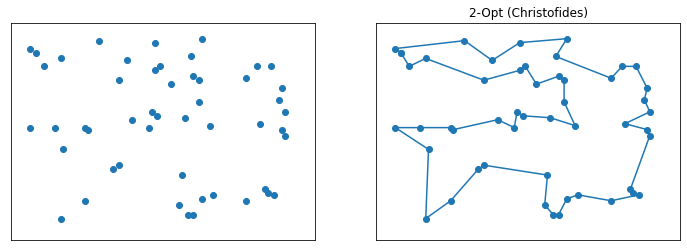

In [81]:
tour, cost = solve_TSP_2Opt(x, y)
print("solved with 2-Opt (Christofides)")
print("cost : ", cost)

visualize_points_solution(x, y, ['', '2-Opt (Christofides)'], tour)

### Problem 5 : For n=20, 50, 100, generate 100 random instances and report the average computational time and the average optimality gap for each method in Questions 3 and 4.

optimality gap for method $m$ : 

$$gap=\frac{|z^*-z_m|}{z^*}, \quad z^* : optimal$$


_reference_ : Kool, Wouter, Herke Van Hoof, and Max Welling. "Attention, learn to solve routing problems!." arXiv preprint arXiv:1803.08475 (2018). (https://arxiv.org/abs/1803.08475)

#### Simple comparison

In [105]:
from julia import LKH
from julia import Concorde

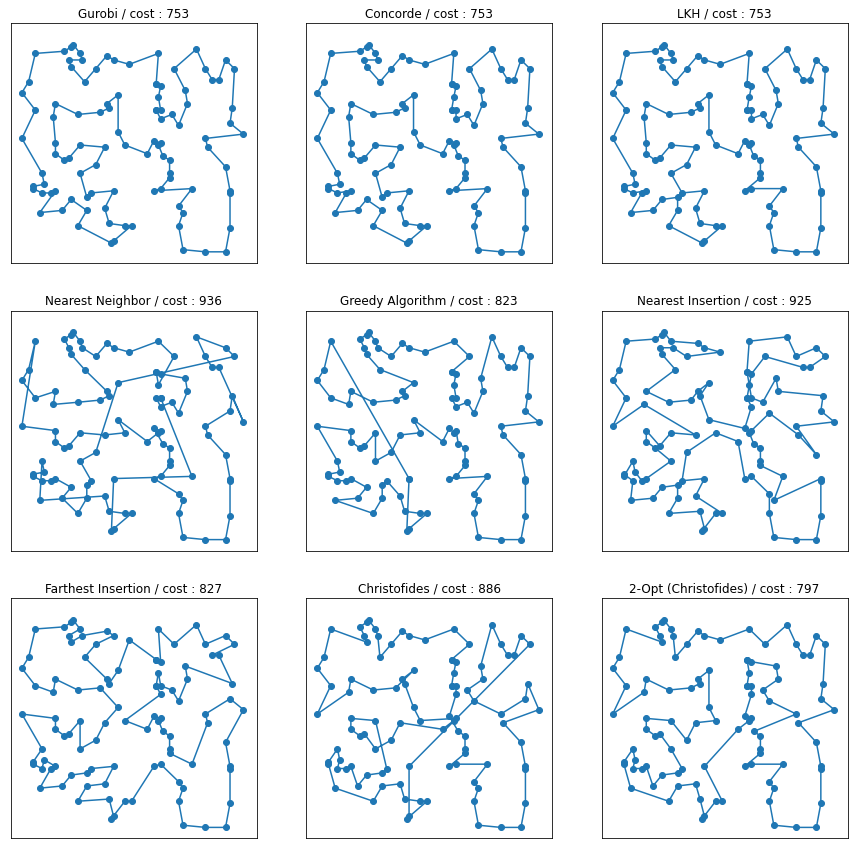

In [143]:
method_list = [
    (Gurobi_solve_TSP, 'Gurobi'),
    (Concorde.solve_tsp, 'Concorde'),
    (LKH.solve_tsp, 'LKH'),
    (solve_TSP_NearestNeighbor, 'Nearest Neighbor'),
    (solve_TSP_GreedyAlgorithm, 'Greedy Algorithm'),
    (solve_TSP_NearestInsertion, 'Nearest Insertion'),
    (solve_TSP_FarthestInsertion, 'Farthest Insertion'),
    (solve_TSP_Christofides, 'Christofides'),
    (solve_TSP_2Opt, '2-Opt (Christofides)'),
]

num_nodes = 100
x, y = generate_instance(num_nodes, np.float64)

tour = []
tour_cost = []
for method in method_list:
    tour_, tour_cost_ = method[0](*(x, y))
    if method[1] == 'Concorde' or method[1] == 'LKH':
        tour_ = np.append(tour_ - 1, [0])
    tour.append(tour_)
    tour_cost.append(tour_cost_)

# visualize
plt.figure(figsize=(15, 15))
for i in range(len(method_list)):
    plt.subplot(3, 3, i+1)
    plt.xlim(-5, 105)
    plt.ylim(-5, 105)
    plt.xticks([])
    plt.yticks([])
    plt.title(method_list[i][1] + ' / cost : ' + str(int(tour_cost[i])))    
    plt.plot(x[tour[i]], y[tour[i]], marker='o')

plt.show()
plt.close('all')